# 마운트 및 세팅


In [63]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/temp/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/temp/'

Mounted at /gdrive
 멋사처럼_프로젝트1_Netflix.ipynb
 매수종목1.txt
 매수종목2.txt
 adult.data
 auto-mpg.csv
 bmi_500.csv
 citibike.csv
 Covid19GenAgeCaseInf.csv
 Covid19InfState.csv
 Covid19NatInfState.csv
 Covid19SidoInfState.csv
 매수종목.csv
 database
 data_mine.csv
 DataNetflixRevenue2020_V2.csv
 DataNetflixSubscriber2020_V2.csv
 data_population.csv
 data_studentlist_en.csv
 example.docx
 height_weight.txt
 Helloword.xlsx
 HelloWorld.xlsx
 KOBIS__.xlsx
 little-char.png
 NetflixsRevenue2018toQ2_2020.csv
 NetflixSubscribersbyCountryfrom2018toQ2_2020.csv
 netflix_titles.csv
 population_number.csv
 ram_price.csv
 ratings_small.txt
 ratings_test.txt
 ratings_train.txt
 sample1.pdf
 sample2.pdf
 sample_merge.pdf
 sample.xlsx
 score.csv
 stock-data.csv
'stock price.xlsx'
'stock valuation.xlsx'
 test.db.db
 Traffic_Accident_2017.csv
 train.csv
 user_id_mean.csv
 user_id_mean.gsheet
 주가데이터.xlsx
 남북한발전전력량.xlsx


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [65]:
!apt -qq -y install fonts-nanum
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


# 데이터셋1: 넷플릭스 프로그램 데이터

데이터를 전반적으로 살펴봤을 때 보기 편하기 만들기 위한 조치를 몇가지 취함

2. director 와 cast 변수에 공백이 있는데 이게 NAN로 바뀐 상황 추후 상황을 보고 결측값을 어떻게 다룰지 생각해 봐야함
  * cast안에 콤마로 된 자료들이 많은데 이것들을 어떻게 다룰지도 생각해봐야함  
      ***-> str.split(expand=True)로 다루면 됨***

3. release year는 원작 기준 배포시기, date_added는 넷플릭스에서 배포된 시기
  * date_added를 주로 쓰게 될 것 같음
  * 데이터를 분기별로 바꿔서 봐야 새로운 데이터와 연동이 됨

4. duration은 movie와 TVshow에 따라 표기가 완전히 다름 따로 분리해서 데이터를 볼 필요가 있음
  * 상영시간은 min을 없애고 int로 바꾸면 보기 편할 것 같음

5. description은 자연어 처리를 해야할 것 같음
  * 감성분석으로 긍정적인 묘사와 부정적인 묘사에 대하여 어느쪽으로 더 극성값이 강한지 알아봐야 할 것 같음 

In [66]:
nflx = pd.read_csv(drive_path + 'netflix_titles.csv',index_col='show_id')
# 데이터 정보
display(nflx.head())
display(nflx.info())
display(nflx.isnull().sum())

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


<class 'pandas.core.frame.DataFrame'>
Index: 7787 entries, s1 to s7787
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          7787 non-null   object
 1   title         7787 non-null   object
 2   director      5398 non-null   object
 3   cast          7069 non-null   object
 4   country       7280 non-null   object
 5   date_added    7777 non-null   object
 6   release_year  7787 non-null   int64 
 7   rating        7780 non-null   object
 8   duration      7787 non-null   object
 9   listed_in     7787 non-null   object
 10  description   7787 non-null   object
dtypes: int64(1), object(10)
memory usage: 730.0+ KB


None

type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

## 데이터 핸들링
*   director,cast 만지기 귀찮으니까 버림
1. date_added 연도 변수 추가, date_added 월 변수 추가
2. listed_in 변수 분할
3. country 변수 정리  
4. ~~rating 변수 정리~~
5. movie와 tvshow 분리한 데이터셋 2개 만들기

  

In [67]:
# 날짜 변수변환을 위한 딕셔너리
quarterdic = {1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4','Unknown':'Unknown'}
# 인덱스 정렬을 위한 리스트
lst = ['Q1 - 2018', 'Q2 - 2018','Q3 - 2018','Q4 - 2018','Q1 - 2019','Q2 - 2019','Q3 - 2019','Q4 - 2019','Q1 - 2020','Q2 - 2020']
yeardic = {'2018-Q1':'Q1 - 2018', '2018-Q2':'Q2 - 2018','2018-Q3':'Q3 - 2018','2018-Q4':'Q4 - 2018','2019-Q1':'Q1 - 2019','2019-Q2':'Q2 - 2019','2019-Q3':'Q3 - 2019','2019-Q4':'Q4 - 2019','2020-Q1':'Q1 - 2020','2020-Q2':'Q2 - 2020'}

In [68]:
# 1. added 연도 월 변수 추가
nflx['date_added'] = nflx['date_added'].fillna('Unknown')
nflx['year_added'] = nflx['date_added'].apply(lambda x : x[-4:len(x)])
# 앞에 공백이 있는 데이터가 있어서 strip으로 빼주고 분리
nflx['date_added'] = nflx['date_added'].apply(str.lstrip)
nflx['month_added'] = nflx['date_added'].apply(lambda x : x.split(' ')[0])
# month name에서 integer로 바꿔줌
nflx['month_added'] = nflx['month_added'].apply(
    lambda x : datetime.datetime.strptime(x,'%B').month 
    if x != 'Unknown' else 'Unknown')
# 다른 넷플릭스 데이터와 연동을 위한 분기별 분리
# unknown이 있어서 계속 람다를 쓰게됨
nflx['q'] = nflx['month_added'].apply(lambda x : quarterdic[x])
nflx['year'] = nflx['year_added'] + '-' +nflx['q']
nflx['monthdate'] = nflx['year_added'] + '-' + nflx['month_added'].astype(str)


In [69]:
# 2. listed_in 변수 정리
countdata=nflx['listed_in'].str.count(',')
print(countdata.max())
'''
콤마 수가 가장 큰 값이 2개인 것으로 보았을 때 카테고리 개수는 세개가 최대인 걸로 알 수 있음
따라서 카테고리는 세개로 보고 나누면 됨
'''
#카테고리 세개로 나누기 expand=True가 핵심임
#str.split으로 나눠주고 -> expand로 데이터프레임으로 바꿔주는 것
nflx[['cat1','cat2','cat3']] = nflx['listed_in'].str.split(",",expand=True)
nflx.head()

2


,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,q,year,monthdate,cat1,cat2,cat3
show_id,,,,,,,,,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,Q3,2020-Q3,2020-8,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,Q4,2016-Q4,2016-12,Dramas,International Movies,None
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,Q4,2018-Q4,2018-12,Horror Movies,International Movies,None
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,Q4,2017-Q4,2017-11,Action & Adventure,Independent Movies,Sci-Fi & Fantasy
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,Q1,2020-Q1,2020-1,Dramas,None,None


In [70]:
# 3. country 변수 정리
nflx['country'] = nflx['country'].fillna('unknown')
nflx.isnull().sum()

countdata = nflx['country'].str.count(',')
print(countdata.max())
'''
인간적으로 11개는 너무 많음 그래서 각 데이터마다 첫번째에 있는 국가만 선택
'''
nflx['country'] =  nflx['country'].apply(lambda x : x.split(',')[0])
nflx.head()

11


,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,q,year,monthdate,cat1,cat2,cat3
show_id,,,,,,,,,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8,Q3,2020-Q3,2020-8,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12,Q4,2016-Q4,2016-12,Dramas,International Movies,None
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018,12,Q4,2018-Q4,2018-12,Horror Movies,International Movies,None
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017,11,Q4,2017-Q4,2017-11,Action & Adventure,Independent Movies,Sci-Fi & Fantasy
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020,1,Q1,2020-Q1,2020-1,Dramas,None,None


In [71]:
# 4. TVshow와 movie 나눠서 보기
tvshow = nflx[nflx['type'] == 'TV Show']
movie= nflx[nflx['type'] == 'Movie']

## 시각화

### 장르 변화량


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


Text(0.5, 1.0, 'Variation of Movie & TV Contents')

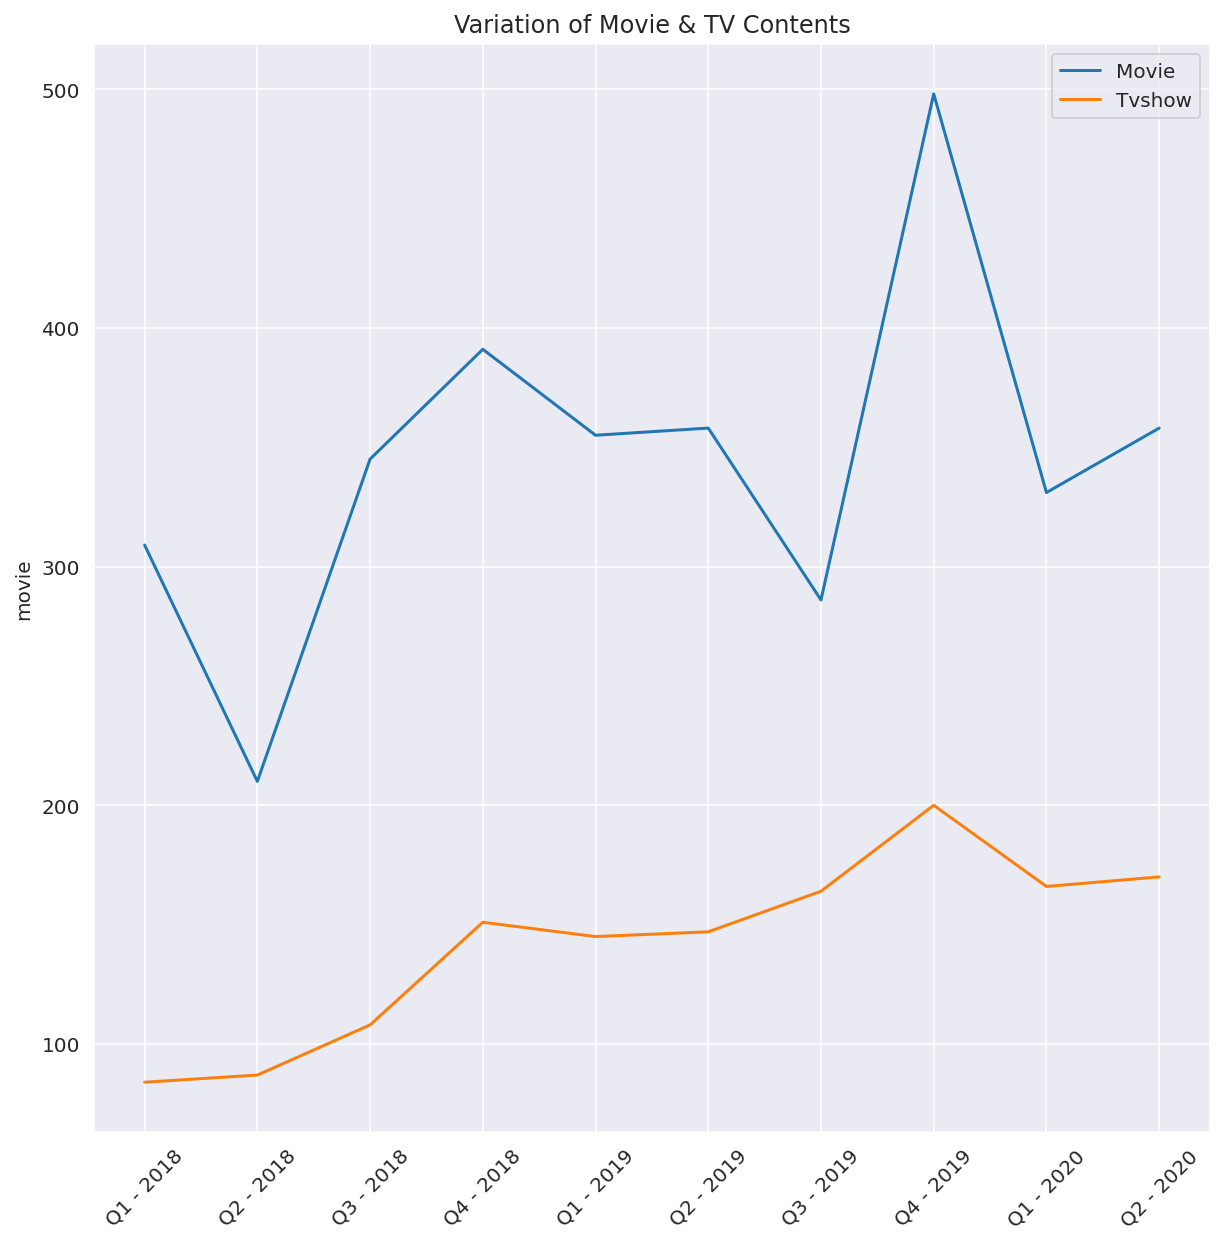

In [72]:
# 차트 만들기 전 정렬 및 인덱스 정리
df1 = pd.DataFrame(movie.value_counts(movie['year']).sort_index())
df1.columns = ['movie']
df2 = pd.DataFrame(tvshow.value_counts(tvshow['year']).sort_index())
df2.columns = ['tvshow']
genre = df1.join(df2)
genre = genre.loc['2018-Q1':'2020-Q2']
genre.index = lst
# 시각화
fig = plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
sns.lineplot(x=genre.index,y=genre.movie,label='Movie')
plt.subplot()
sns.lineplot(x=genre.index,y=genre.tvshow,label='Tvshow')
plt.xticks(rotation=45)
plt.title("Variation of Movie & TV Contents")

### 국가별 컨텐츠 수 TOP20
가설 1을 지지해줄 수 있는 자료
South korea contents가 넷플릭스 컨텐츠 빈도수 중 6위를 차지하고 있음, 한국콘텐츠가 증가하고 있다

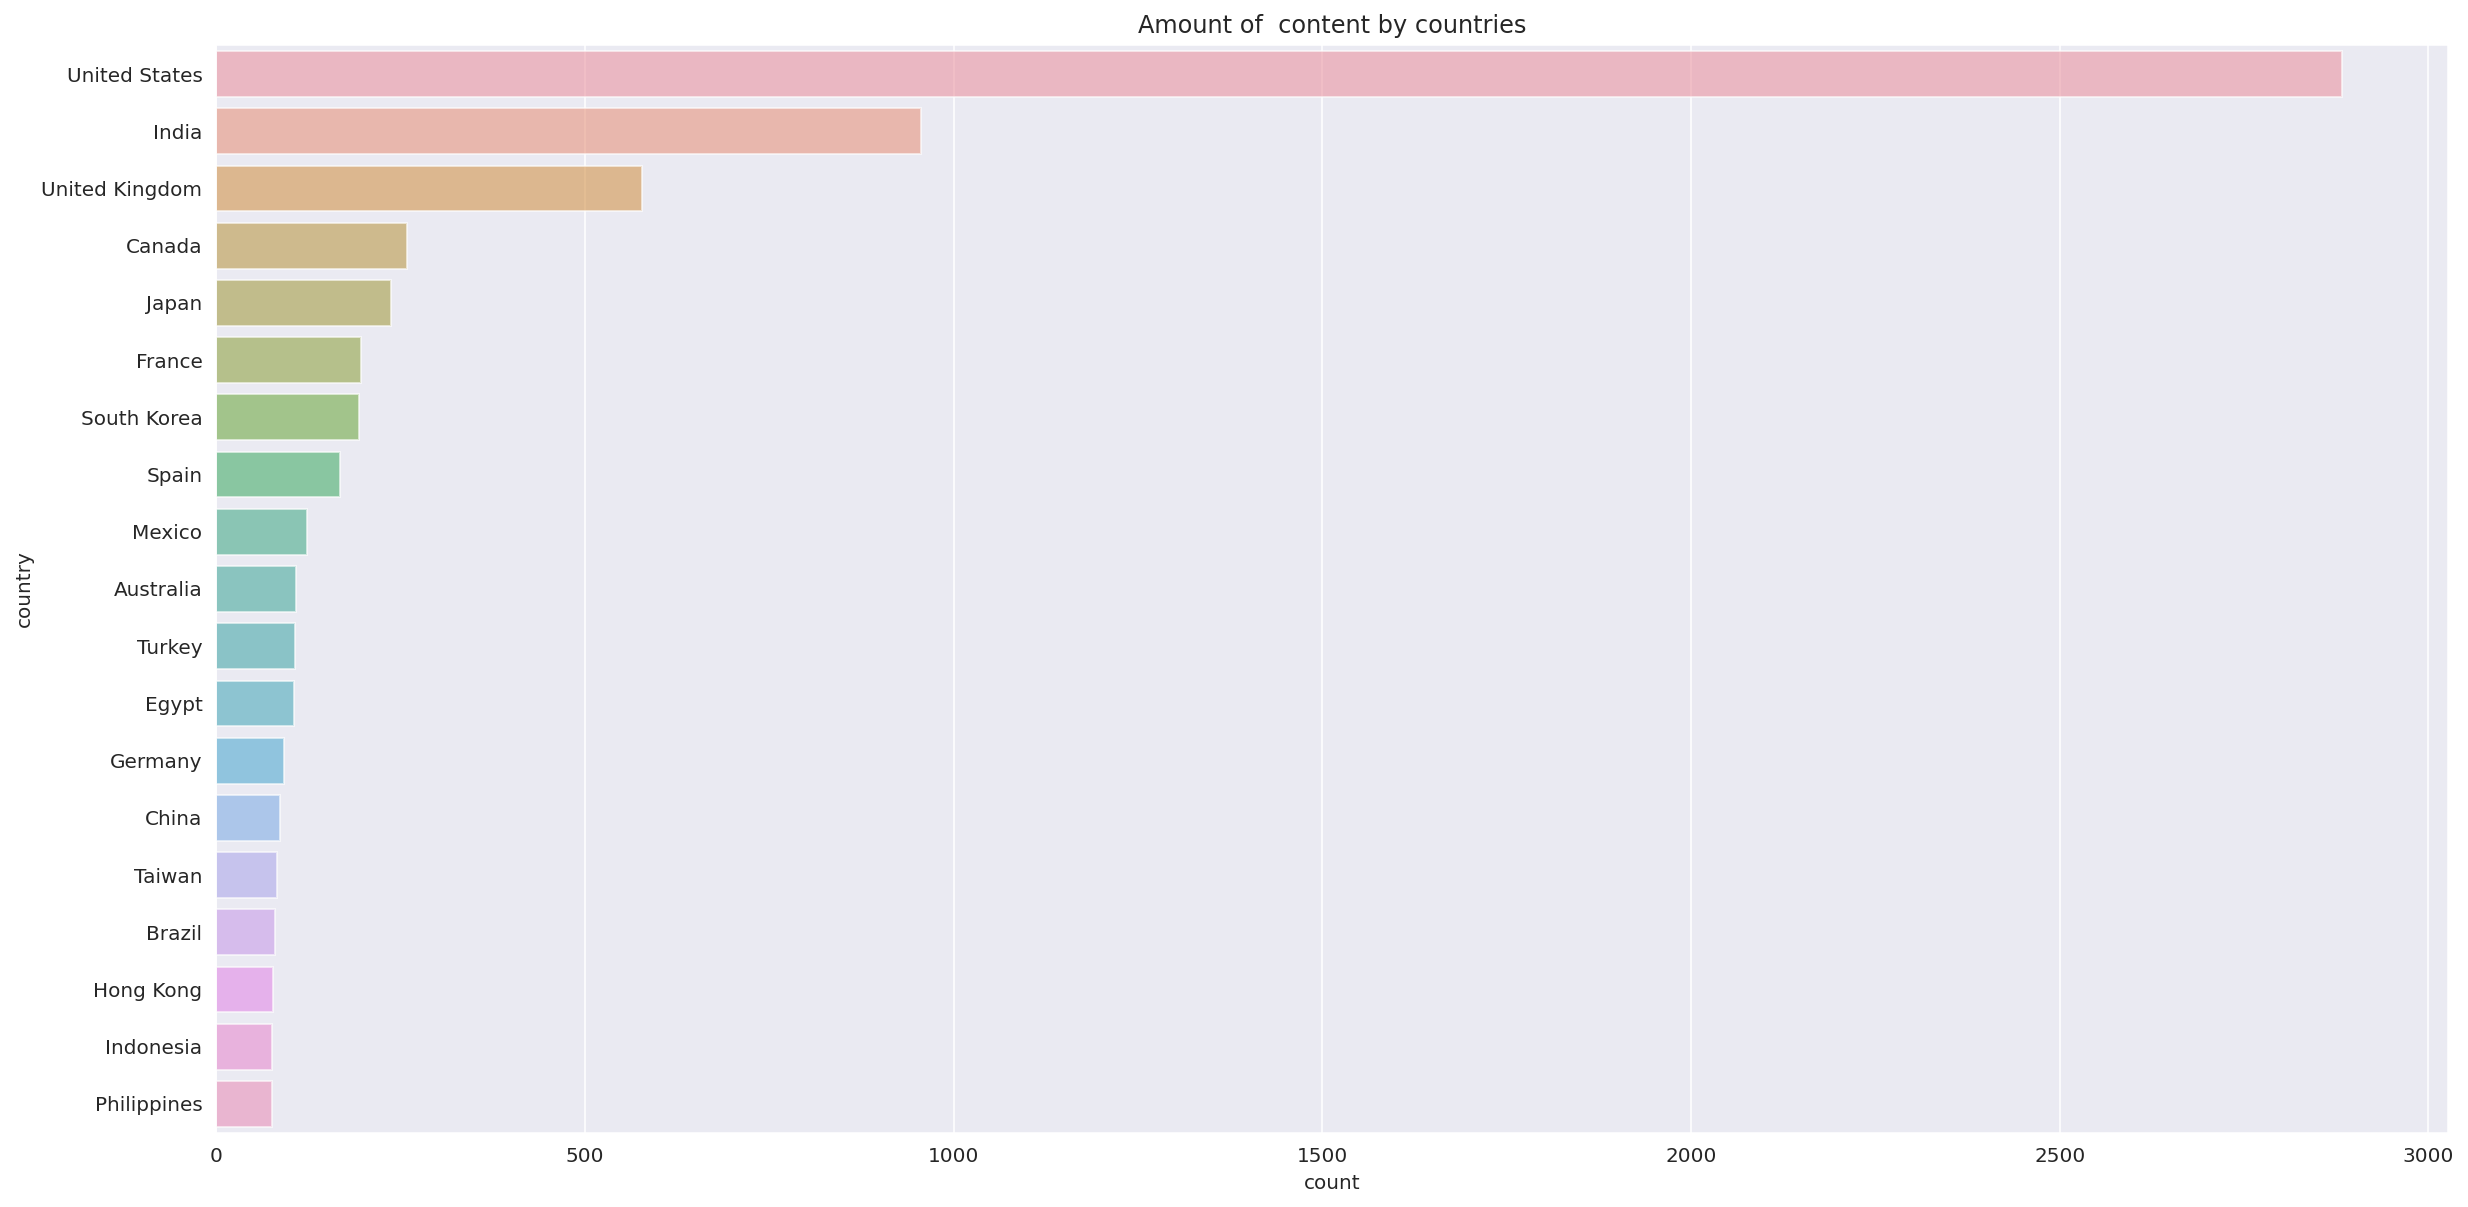

In [73]:
country = pd.DataFrame(nflx.value_counts('country')).head(20)     #컨텐츠 개수가 많은 top20
country= country[country.index != 'unknown']      # 국가 unknown은 제외함
country.columns = ['count'] 
fig = plt.figure(figsize=(20,10))
plt.title("Amount of  content by countries")
sns.barplot(y = country.index,x = country['count'],alpha=0.6)
plt.show()

### 컨텐츠 종류 분포 TOP30

가설 1 지지 아래 첫번째 시각화를 보면 Tvshow 부분에 한국드라마가 꽤 많은 컨텐츠로 다뤄지는 것을 볼 수있음. 이는 넷플릭스 컨텐츠 중 한국 컨텐츠가 꽤 크게 차지하고 있음을 보여준다, 

In [74]:
# 5. 카테고리 변수 데이터프레임 따로 만들기
ca1 = nflx[['type','cat1','year','monthdate']]
ca1.columns=['type','cat','year','monthdate']
ca2 = nflx[['type','cat2','year','monthdate']]
ca2.columns=['type','cat','year','monthdate']
ca3 = nflx[['type','cat3','year','monthdate']]
ca3.columns=['type','cat','year','monthdate']
cat_df = pd.concat([ca1,ca2,ca3],ignore_index = True) 
cat_df.index = cat_df['year'].sort_index()
temp = cat_df.T.loc[:,['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3','2019-Q4','2020-Q1','2020-Q2']]
cat_df = temp.T
cat_df.dropna()

# 가장 많은 컨텐츠

,type,cat,year,monthdate
year,,,,
2018-Q1,Movie,Horror Movies,2018-Q1,2018-3
2018-Q1,Movie,Action & Adventure,2018-Q1,2018-2
2018-Q1,Movie,Documentaries,2018-Q1,2018-3
2018-Q1,TV Show,Crime TV Shows,2018-Q1,2018-3
2018-Q1,Movie,Action & Adventure,2018-Q1,2018-3
...,...,...,...,...
2020-Q2,Movie,Thrillers,2020-Q2,2020-6
2020-Q2,Movie,Romantic Movies,2020-Q2,2020-4
2020-Q2,Movie,Romantic Movies,2020-Q2,2020-6


In [75]:
#카테고리 공백 제거
cat_df['cat']=cat_df['cat'].str.strip()
print(cat_df['cat'].unique())

movie = cat_df[cat_df['type']=='Movie']
tvshow = cat_df[cat_df['type']=='TV Show']

cat_dist_m= pd.DataFrame(movie.value_counts('cat'))
cat_dist_m.columns = ['Count']

cat_dist_tv= pd.DataFrame(tvshow.value_counts('cat'))
cat_dist_tv.columns = ['Count']

['Horror Movies' 'Action & Adventure' 'Documentaries' 'Crime TV Shows'
 'Dramas' 'Comedies' 'Anime Series' 'Stand-Up Comedy'
 'International Movies' 'Children & Family Movies' 'Independent Movies'
 'Thrillers' 'International TV Shows' "Kids' TV" 'Docuseries'
 'British TV Shows' 'Movies' 'TV Comedies' 'Classic & Cult TV'
 'Music & Musicals' 'TV Shows' 'Anime Features' 'Romantic TV Shows'
 'Sci-Fi & Fantasy' 'TV Action & Adventure' 'Stand-Up Comedy & Talk Shows'
 'TV Dramas' None 'Romantic Movies' 'Reality TV' 'Sports Movies'
 'TV Horror' 'Spanish-Language TV Shows' 'Science & Nature TV'
 'LGBTQ Movies' 'Korean TV Shows' 'Faith & Spirituality'
 'TV Sci-Fi & Fantasy' 'Cult Movies' 'TV Thrillers' 'TV Mysteries'
 'Teen TV Shows' 'Classic Movies']


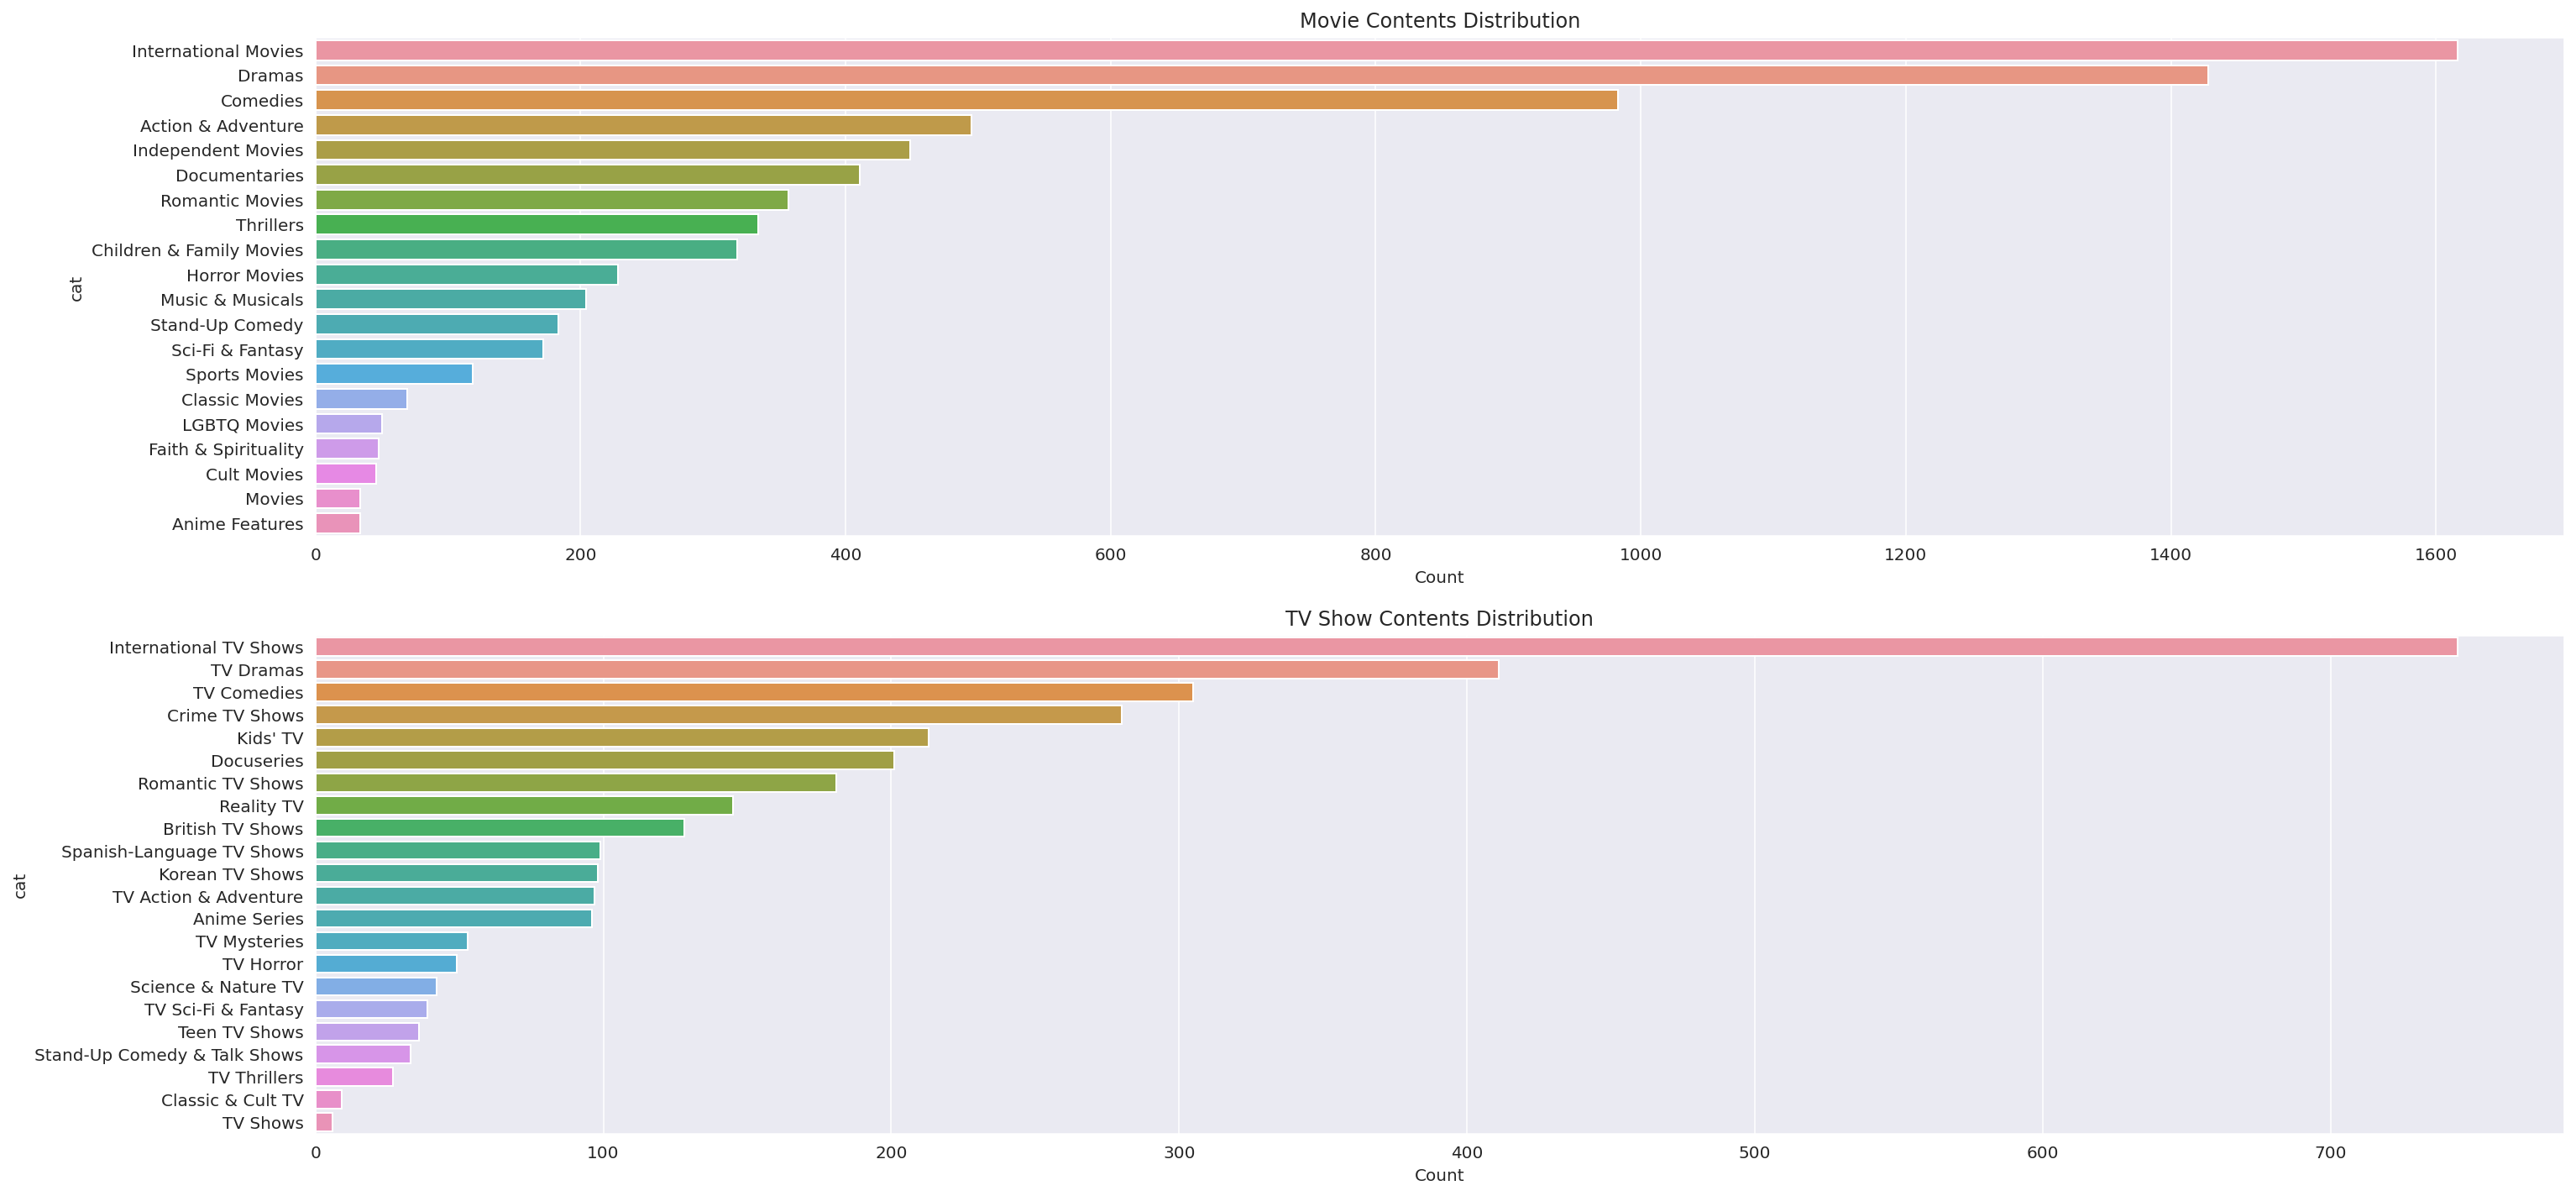

In [76]:
#시각화
fig = plt.figure(figsize=(24,12))

fig.add_subplot(2,1,1)
plt.title('Movie Contents Distribution')
sns.barplot(y = cat_dist_m.index, x = cat_dist_m.Count)
plt.tick_params(labelsize=10)

fig.add_subplot(2,1,2)
plt.title('TV Show Contents Distribution')
sns.barplot(y = cat_dist_tv.index, x = cat_dist_tv.Count)
plt.tick_params(labelsize=10)


### 시기별 컨텐츠 변화량

다뤄지는 컨텐츠 장르가 너무 많아서 가장 많이 다뤄지는 장르중 15개만 선택해서 시각화를 진행하였음 어떤 종류가 있는지 참고 하는 정도 여유가 삽입 

In [90]:
cat_df= cat_df[['cat','year']]
cat_df['Counts'] = np.zeros(len(cat_df))
cat_df.index = range(1,len(cat_df)+1)
cat_df2 = cat_df.groupby(['cat','year']).count().reset_index()
cat_df2.index = cat_df2['year'].sort_index()
cat_df2

#컨텐츠 변화량중 가장 많은 10개 컨텐츠 추출: list a
temp = pd.DataFrame(cat_df2.groupby('cat').sum('Counts'))
a = temp.sort_values(by='Counts',ascending=False).head(15).index
a=list(a)
a


#상관분석을 위한 dataframe:cat_df3
cat_df3 = pd.DataFrame()
for i in a:
  temp = cat_df2[cat_df2['cat'] == i]
  cat_df3=pd.concat([cat_df3,temp['Counts']],axis=1)
cat_df3.columns = a
cat_df3.index = lst
display(cat_df3)

#시각화를 위한 dataframe:cat_df4
cat_df4 = pd.DataFrame()
for i in a:
  temp = cat_df2[cat_df2['cat'] == i]
  cat_df4=pd.concat([cat_df4,temp])
display(cat_df4)

# 데이터 재구조화가 필요하다고 판단
# newdf = pd.pivot(cat_df, index = 'index', columns='cat',values = 'year')
# newdf.p
# modify_df = newdf.groupby('year').count()
# modify_df
# final_cat_data = modify_df[[]

,International Movies,Dramas,Comedies,International TV Shows,Action & Adventure,Independent Movies,Documentaries,TV Dramas,Romantic Movies,Thrillers,Children & Family Movies,TV Comedies,Crime TV Shows,Horror Movies,Kids' TV
Q1 - 2018,160,127,57,47,37,40,55,28,22,32,22,17,25,19,10
Q2 - 2018,95,83,44,50,25,31,32,26,21,16,18,27,15,9,19
Q3 - 2018,210,157,103,58,60,54,36,29,32,32,16,22,21,32,17
Q4 - 2018,212,167,97,69,56,34,47,35,36,36,29,37,29,21,23
Q1 - 2019,162,169,97,80,51,66,42,49,32,27,38,27,29,25,17
Q2 - 2019,175,132,111,85,44,54,48,48,38,35,28,42,31,32,18
Q3 - 2019,105,91,73,82,38,32,54,49,23,34,25,19,29,15,26
Q4 - 2019,199,204,171,112,89,53,45,48,64,50,57,47,34,29,29
Q1 - 2020,92,127,103,80,48,45,24,52,39,39,48,32,34,29,34
Q2 - 2020,206,171,127,81,47,40,28,47,50,33,37,35,33,17,20


,cat,year,Counts
year,,,
2018-Q1,International Movies,2018-Q1,160
2018-Q2,International Movies,2018-Q2,95
2018-Q3,International Movies,2018-Q3,210
2018-Q4,International Movies,2018-Q4,212
2019-Q1,International Movies,2019-Q1,162
...,...,...,...
2019-Q2,Kids' TV,2019-Q2,18
2019-Q3,Kids' TV,2019-Q3,26
2019-Q4,Kids' TV,2019-Q4,29


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

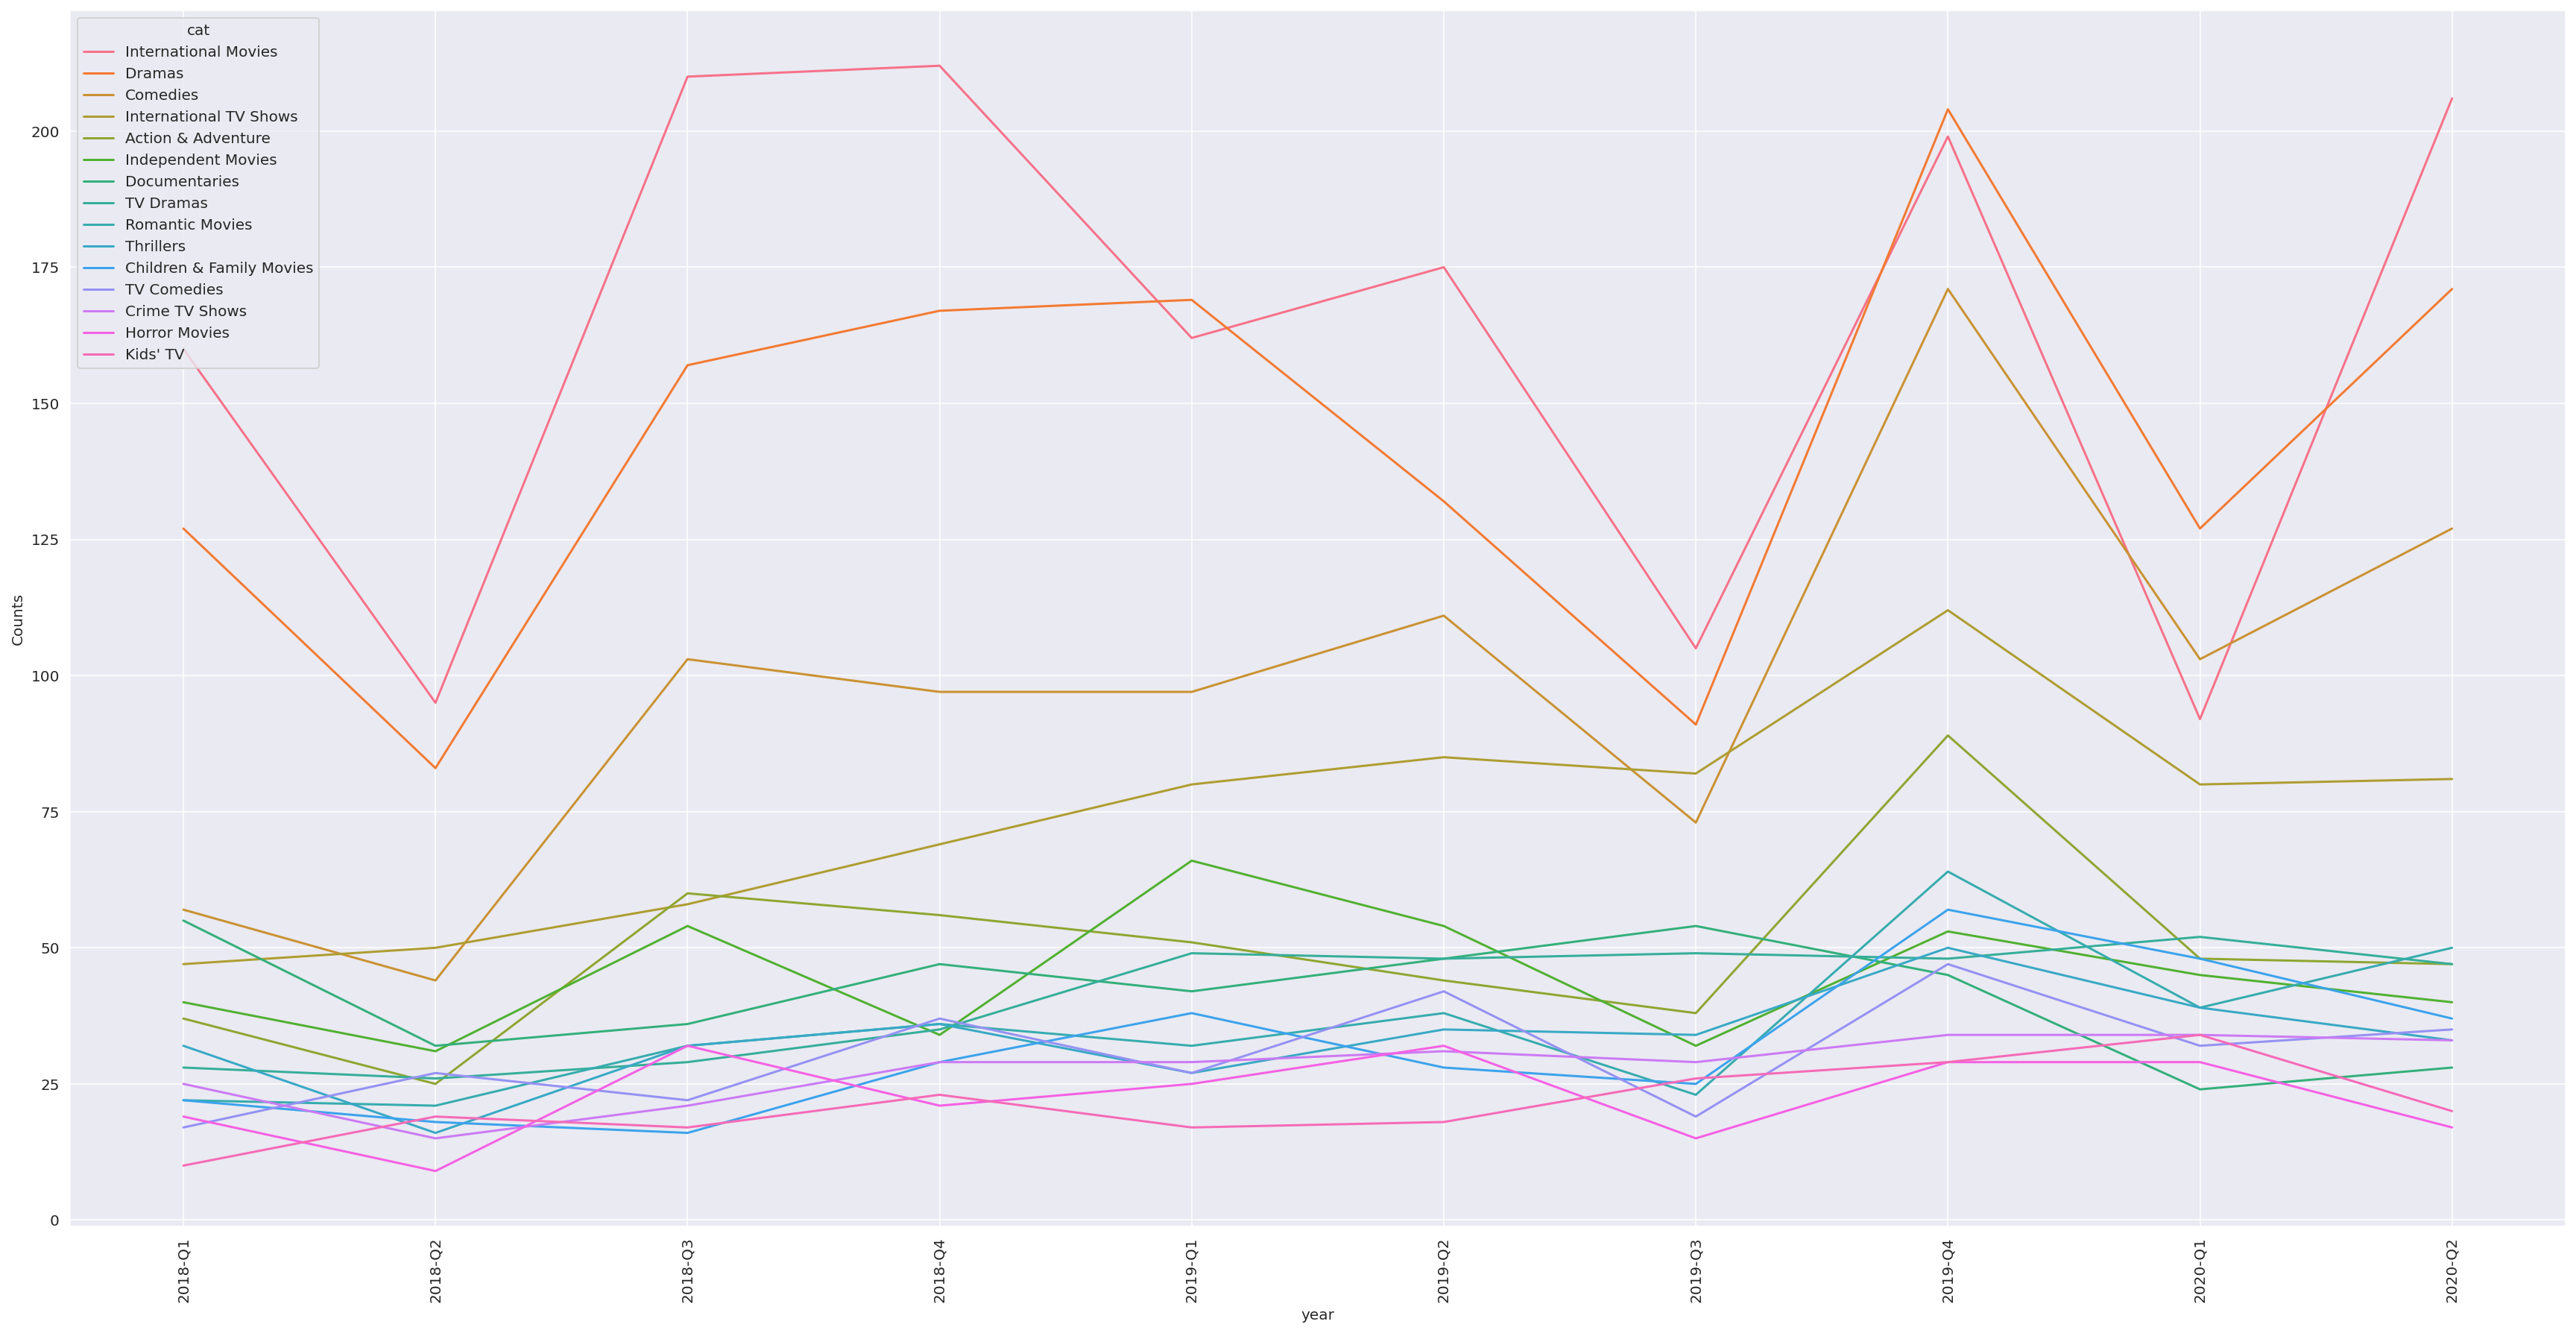

In [78]:
# 시각화
fig = plt.figure(figsize=(30,15))
sns.lineplot(x = 'year',y = 'Counts', hue = 'cat',data=cat_df4)
plt.xticks(rotation = 90)

# 데이터셋2: 넷플릭스 구독자 및 수익

In [79]:
revenue = pd.read_csv(drive_path + 'DataNetflixRevenue2020_V2.csv')
scb = pd.read_csv(drive_path + 'DataNetflixSubscriber2020_V2.csv')
revenue_spread = pd.read_csv(drive_path + 'NetflixsRevenue2018toQ2_2020.csv')
scb_spread = pd.read_csv(drive_path + 'NetflixSubscribersbyCountryfrom2018toQ2_2020.csv')
# 데이터 정보
display(revenue.head())
display(scb.head())
display(revenue_spread.head())
display(scb_spread.head())

,Area,Years,Revenue
0,United States and Canada,Q1 - 2018,1976157000
1,"Europe, Middle East and Africa",Q1 - 2018,886649000
2,Latin America,Q1 - 2018,540182000
3,Asia-Pacific,Q1 - 2018,199117000
4,United States and Canada,Q2 - 2018,2049546000


,Area,Years,Subscribers
0,United States and Canada,Q1 - 2018,60909000
1,"Europe, Middle East and Africa",Q1 - 2018,29339000
2,Latin America,Q1 - 2018,21260000
3,Asia-Pacific,Q1 - 2018,7394000
4,United States and Canada,Q2 - 2018,61870000


,Area,Q1 - 2018,Q2 - 2018,Q3 - 2018,Q4 - 2018,Q1 - 2019,Q2 - 2019,Q3 - 2019,Q4 - 2019,Q1 - 2020,Q2 - 2020
0,United States and Canada,1976157000,2049546000,2094850000,2160979000,2256851000,2501199000,2621250000,2671908000,2702776000,2839670000
1,"Europe, Middle East, and Africa",886649000,975497000,1004749000,1096812000,1233379000,1319087000,1428040000,1562561000,1723474000,1892537000
2,Latin America,540182000,568071000,562307000,567137000,630472000,677136000,741434000,746392000,793453000,785368000
3,Asia-Pacific,199117000,221252000,248691000,276756000,319602000,349494000,382304000,418121000,483660000,569140000


,Area,Q1 - 2018,Q2 - 2018,Q3 - 2018,Q4 - 2018,Q1 - 2019,Q2 - 2019,Q3 - 2019,Q4 - 2019,Q1 - 2020,Q2 - 2020
0,United States and Canada,60909000,61870000,63010000,64757000,66633000,66501000,67114000,67662000,69969000,72904000
1,"Europe, Middle East, and Africa",29339000,31317000,33836000,37818000,42542000,44229000,47355000,51778000,58734000,61483000
2,Latin America,21260000,22795000,24115000,26077000,27547000,27890000,29380000,31417000,34318000,36068000
3,Asia-Pacific,7394000,8372000,9461000,10607000,12141000,12942000,14485000,16233000,19835000,22492000


## 시각화

전체적으로 넷플릭스 수익과 구독자수가  계속해서 증가하고 코로나가 터진 기점으로 구독자수가 모두 급등하는 것을 볼 수 있음
아시아가 높아지는데, 가장위에 콘텐츠 개수를 참고했을 때 아시아 중에서도 한국이 꽤나 큰 부분을 차지하고 있기 때문에 어느정도 한국의 구독자 수를 대표할 수 있다고 봄

In [80]:
#시각화를 위한 데이터 분리
#각 지역별 revenue
usa_revenue = revenue[ revenue[ 'Area' ] == 'United States and Canada' ][ [ 'Area','Years','Revenue' ] ]
eurafrica_revenue = revenue[revenue['Area']=='Europe,  Middle East and Africa'][['Area','Years','Revenue']]
latin_revenue=revenue[revenue['Area']=='Latin America'][['Area','Years','Revenue']]
asia_revenue=revenue[revenue['Area']=='Asia-Pacific'][['Area','Years','Revenue']]

#분기별 revenue 평균
mean_dic={}
for i in range(len(revenue_spread.columns)-1):
  mean_dic[revenue_spread.columns[i+1]]=(revenue_spread.iloc[:,i+1].mean())
mean_revenue = pd.DataFrame(mean_dic.values(),index = mean_dic.keys(), columns = ['revenue'])


#긱 지역별 subscriber
usa_scb=scb[scb['Area']=='United States and Canada'][['Area','Years','Subscribers']]
eurafrica_scb=scb[scb['Area']=='Europe,  Middle East and Africa'][['Area','Years','Subscribers']]
latin_scb=scb[scb['Area']=='Latin America'][['Area','Years','Subscribers']]
asia_scb=scb[scb['Area']=='Asia-Pacific'][['Area','Years','Subscribers']]

#분기별 subscriber 평균
mean_dic={}
for i in range(len(scb_spread.columns)-1):
  mean_dic[scb_spread.columns[i+1]]= (scb_spread.iloc[:,i+1].mean())
mean_scb = pd.DataFrame(mean_dic.values(),index = mean_dic.keys(), columns = ['subscribers'])

Text(0.5, 1.0, 'Subscribers for Quarter')

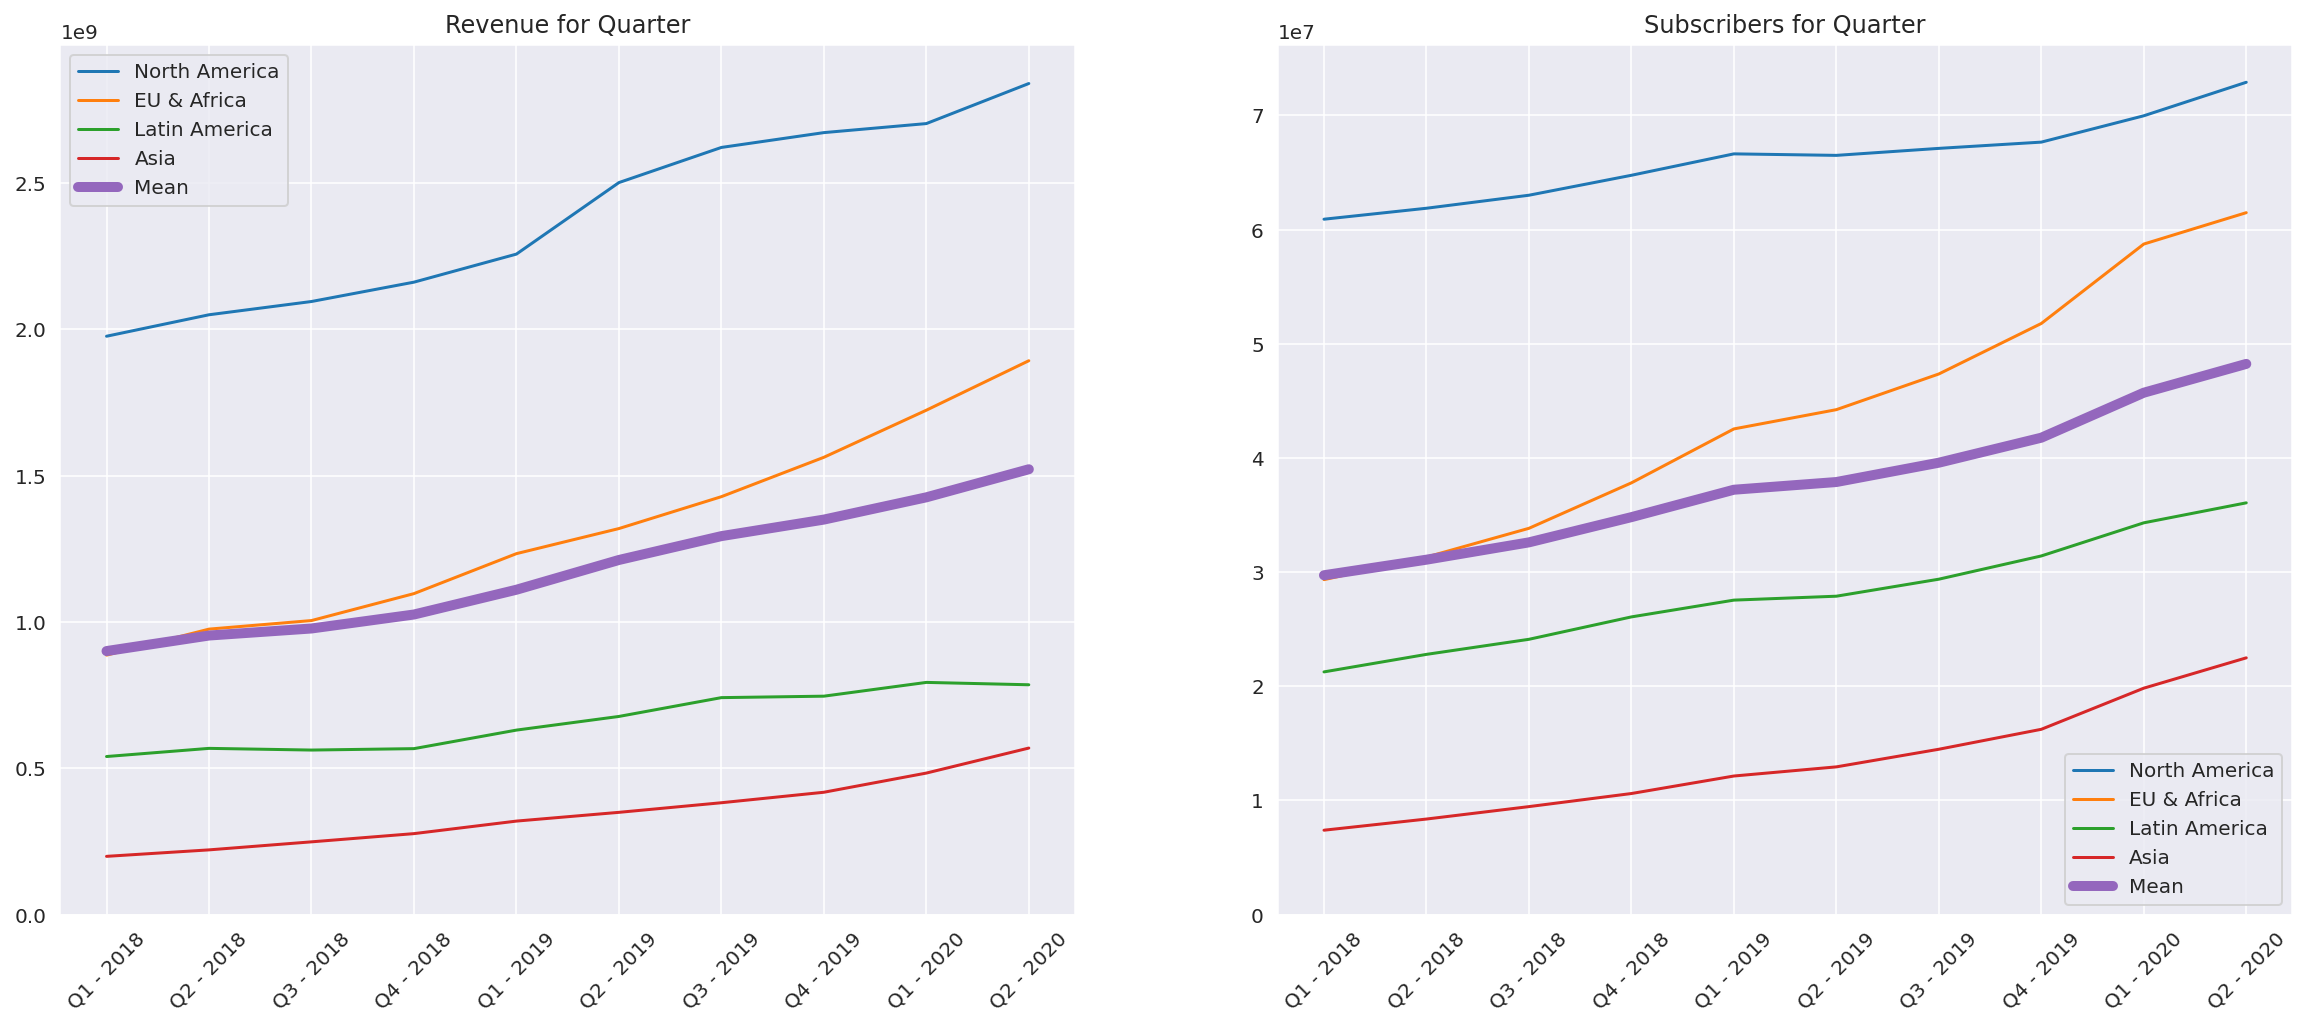

In [81]:
# 분기별 수익시각화
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,2,1)
plt.plot(usa_revenue['Years'],usa_revenue['Revenue'],label = 'North America')
plt.plot(eurafrica_revenue['Years'],eurafrica_revenue['Revenue'], label = 'EU & Africa')
plt.plot(latin_revenue['Years'],latin_revenue['Revenue'], label = 'Latin America')
plt.plot(asia_revenue['Years'],asia_revenue['Revenue'], label = 'Asia')
plt.plot(mean_revenue.index,mean_revenue['revenue'],label = 'Mean', lw = '5')

plt.xticks(rotation=45)
plt.yticks(range(0,3000000000,500000000))
plt.legend()
plt.title('Revenue for Quarter')


# 분기별 구독자수 시각화
fig.add_subplot(1,2,2)
plt.plot(usa_scb['Years'],usa_scb['Subscribers'],label = 'North America')
plt.plot(eurafrica_scb['Years'],eurafrica_scb['Subscribers'],label = 'EU & Africa')
plt.plot(latin_scb['Years'],latin_scb['Subscribers'],label = 'Latin America')
plt.plot(asia_scb['Years'],asia_scb['Subscribers'],label = 'Asia')
plt.plot(mean_scb.index,mean_scb['subscribers'],label = 'Mean', lw = '5')

plt.xticks(rotation=45)
plt.yticks(range(0,80000000,10000000))
plt.legend()
plt.title('Subscribers for Quarter')


# 데이터셋3: 영화관 데이터


In [82]:
# 데이터 불러오기 및 기본 세팅
movie = pd.read_excel(drive_path+'KOBIS__.xlsx', index_col = '순번')
moviedf = movie[['영화명','개봉일','전국\n매출액','전국\n관객수']]
moviedf.columns = ['name','releaseday','revenue','customers']

moviedf.head()

,name,releaseday,revenue,customers
순번,,,,
1,극한직업,2019-01-23,139647979516,16264944
2,어벤져스: 엔드게임,2019-04-24,122182694160,13934592
3,겨울왕국 2,2019-11-21,114810421450,13747792
4,알라딘,2019-05-23,106983620359,12555894
5,신과함께-인과 연,2018-08-01,102476768809,12253247


## 데이터 핸들링

In [83]:
#timestamp
moviedf['releaseday'] = pd.to_datetime(moviedf['releaseday'])
moviedf['year'] = moviedf['releaseday'].dt.year
moviedf['year'] = moviedf['year'].astype('str')

#quarter switch
moviedf['q'] = moviedf['releaseday'].dt.quarter
moviedf['q'] = moviedf['q'].replace(1,'Q1')
moviedf['q'] = moviedf['q'].replace(2,'Q2')
moviedf['q'] = moviedf['q'].replace(3,'Q3')
moviedf['q'] = moviedf['q'].replace(4,'Q4')

#datematching
moviedf['Years'] = moviedf['q'] + ' - ' + moviedf['year']
moviedf['years'] = moviedf['year'] + ' - ' + moviedf['q']

# remove 2016 2017 
moviedf = moviedf[moviedf['year']!='2016']
moviedf = moviedf[moviedf['year']!='2017']

#remove 2020 q3 q4
moviedf = moviedf[moviedf['Years'] != 'Q3 - 2020']
moviedf = moviedf[moviedf['Years'] != 'Q4 - 2020']


moviedf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,name,releaseday,revenue,customers,year,q,Years,years
순번,,,,,,,,
1,극한직업,2019-01-23,139647979516,16264944,2019,Q1,Q1 - 2019,2019 - Q1
2,어벤져스: 엔드게임,2019-04-24,122182694160,13934592,2019,Q2,Q2 - 2019,2019 - Q2
3,겨울왕국 2,2019-11-21,114810421450,13747792,2019,Q4,Q4 - 2019,2019 - Q4
4,알라딘,2019-05-23,106983620359,12555894,2019,Q2,Q2 - 2019,2019 - Q2
5,신과함께-인과 연,2018-08-01,102476768809,12253247,2018,Q3,Q3 - 2018,2018 - Q3


## 데이터 시각화

영화 개봉 개수와 수익, 고객수를 시각화 했다
영화 개봉 수 는 코로나가 터지는 시기에는 증가했지만 본격적으로 코로나의 여파로 인한 사회적 거리두기 등으로 개봉된 영화의 개수가 줄어드는 것을 볼 수 있다  
그리고 영화관 수익과 고객수는 아주 비슷한 분포를 보인다. 코로나가 터진 직후 급락한다.



In [ ]:
# 영화 개봉 개수
movie_count = pd.DataFrame(moviedf['years'].value_counts())
movie_visual = movie_count.sort_index()

#원하는 칼럼 정렬이 제대로 안돼서 하게된 절차
temp = movie_visual.T

temp.columns = lst
movie_visual = temp.T

#시각화
x = movie_visual.index
y = movie_visual.values
plt.plot(x,y)
plt.xticks(rotation=90)
plt.title('Number of released movies per quarter')

Text(0.5, 1.0, 'Number of released movies per quarter')

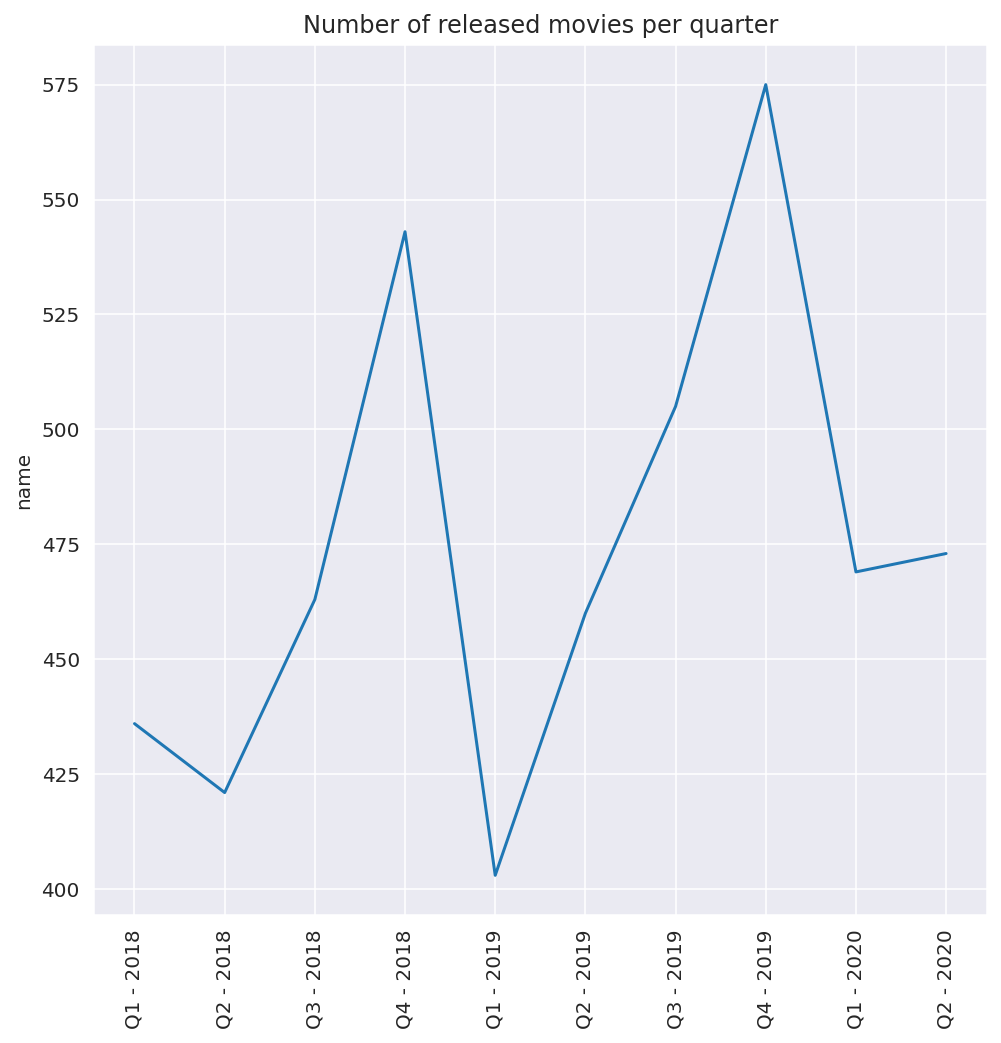

In [85]:
# 더 쉬운 방법이 있었음...
count = moviedf.groupby('years').count()
lst = ['Q1 - 2018', 'Q2 - 2018','Q3 - 2018','Q4 - 2018','Q1 - 2019','Q2 - 2019','Q3 - 2019','Q4 - 2019','Q1 - 2020','Q2 - 2020']
count.index = lst

x = count.index
y = count.name

#시각화
fig=plt.figure(figsize=(8,8))
# sns.barplot(x=x,y=y,orientation='vertical')
sns.lineplot(x=x,y=y)
plt.xticks(rotation=90)
plt.title('Number of released movies per quarter')

Text(0.5, 1.0, 'customer of Movie theater')

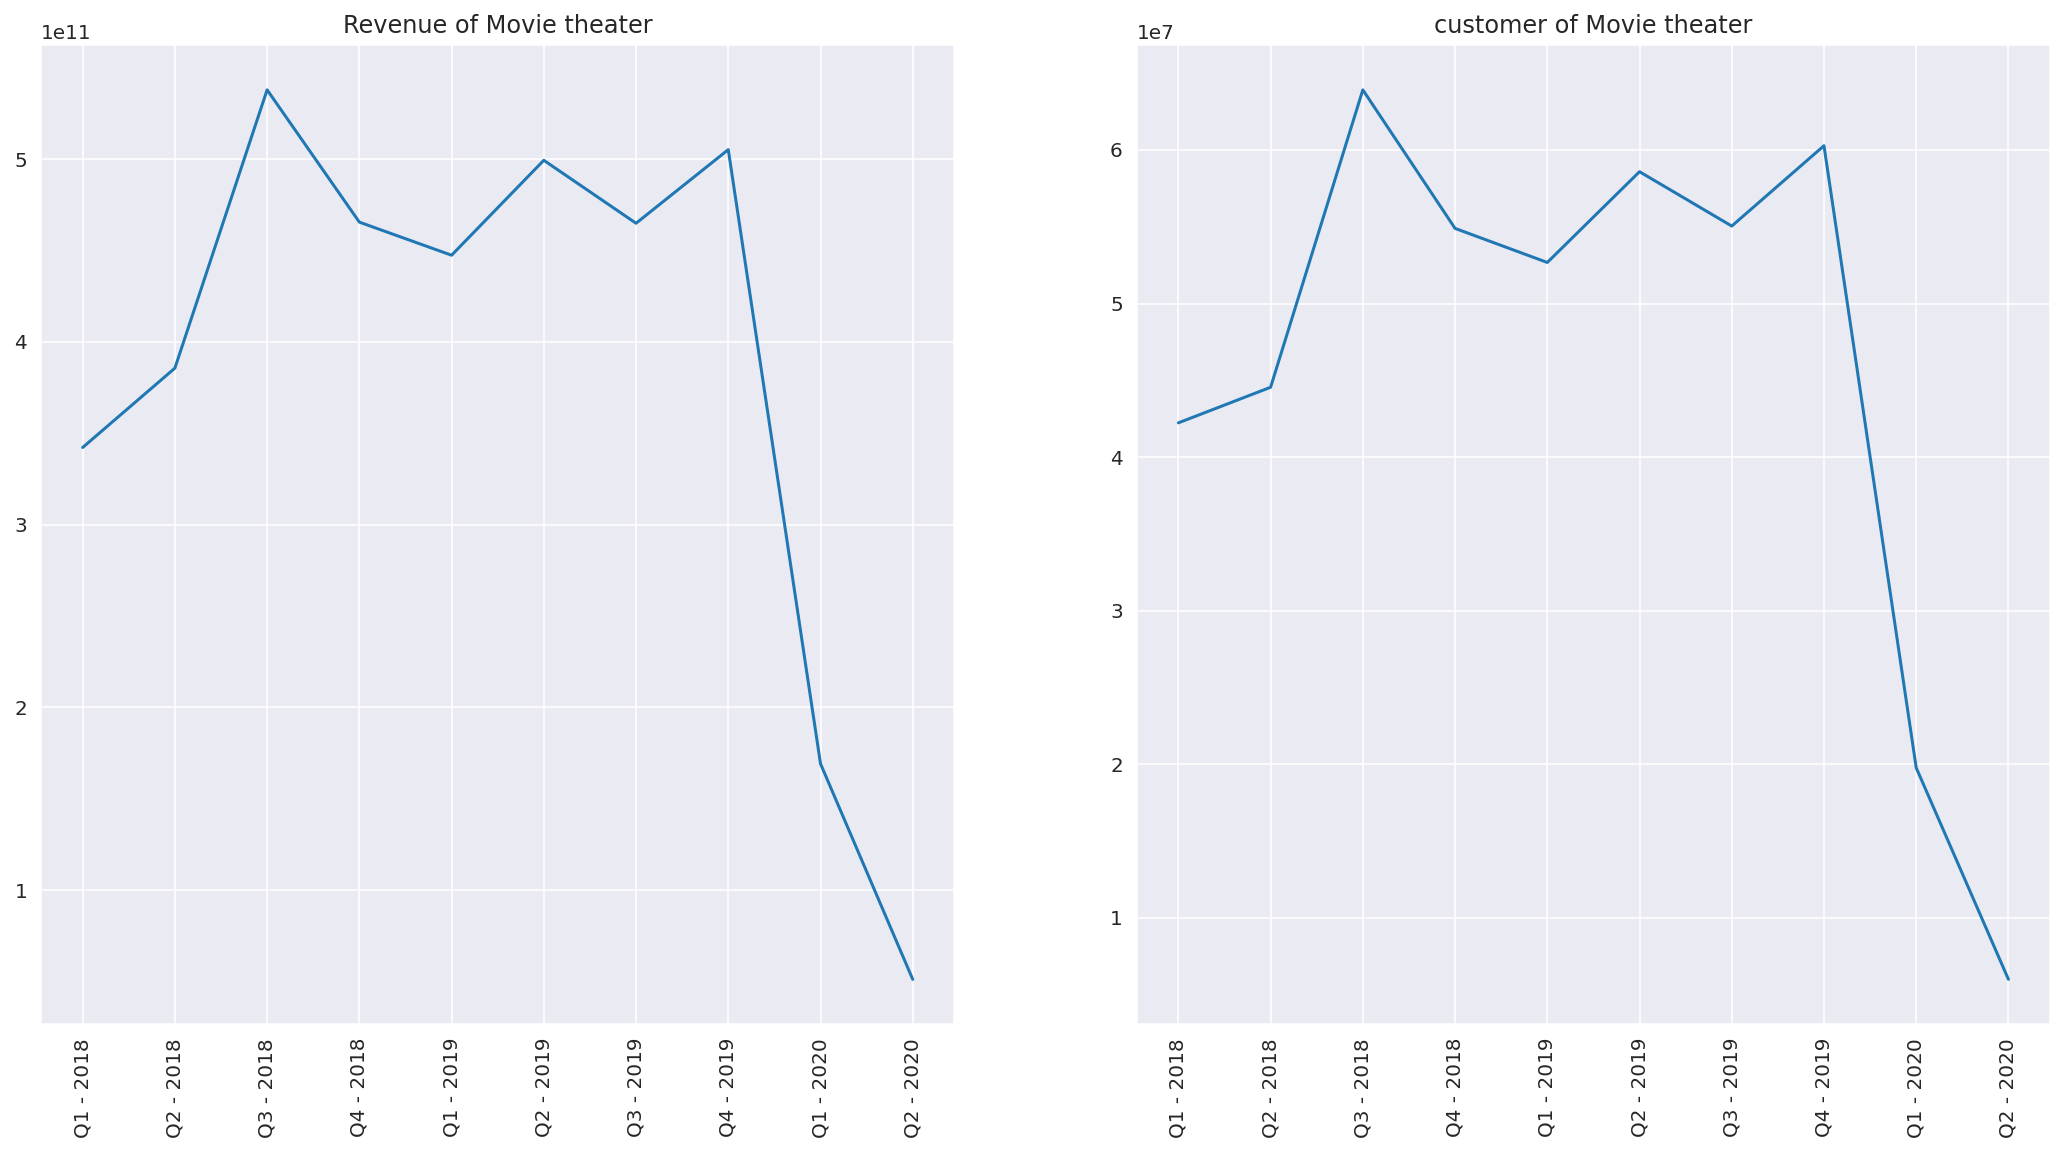

In [86]:
# 분기별 수익 합
sum_r_c = moviedf.groupby('years').sum('revenue')
sum_r_c.index = lst

x=sum_r_c.index
y1 = sum_r_c['revenue']
y2 = sum_r_c['customers']

fig = plt.figure(figsize=(18,9))

fig.add_subplot(1,2,1)
plt.plot(x,y1)
plt.xticks(rotation=90)
plt.title('Revenue of Movie theater')

fig.add_subplot(1,2,2)
plt.plot(x,y2)
plt.xticks(rotation=90)
plt.title('customer of Movie theater')


In [87]:
# 분기별 개봉 영화 개수, 영화 수익, 영화 관객 dataframe
final_mv_df = sum_r_c.join(count.name)
asia_revenue= asia_scb.set_index('Years')
#넷플릭스 구독자 수 병합
final_mv_df= final_mv_df.join(asia_revenue.Subscribers)

final_mv_df.columns = ['movie_revenue','movie_customers','movie_count','neflixsubscriber']
display(final_mv_df.corr())


,movie_revenue,movie_customers,movie_count,neflixsubscriber
movie_revenue,1.000000,0.999227,0.202625,-0.664907
movie_customers,0.999227,1.000000,0.208344,-0.670818
movie_count,0.202625,0.208344,1.000000,0.303699
neflixsubscriber,-0.664907,-0.670818,0.303699,1.000000


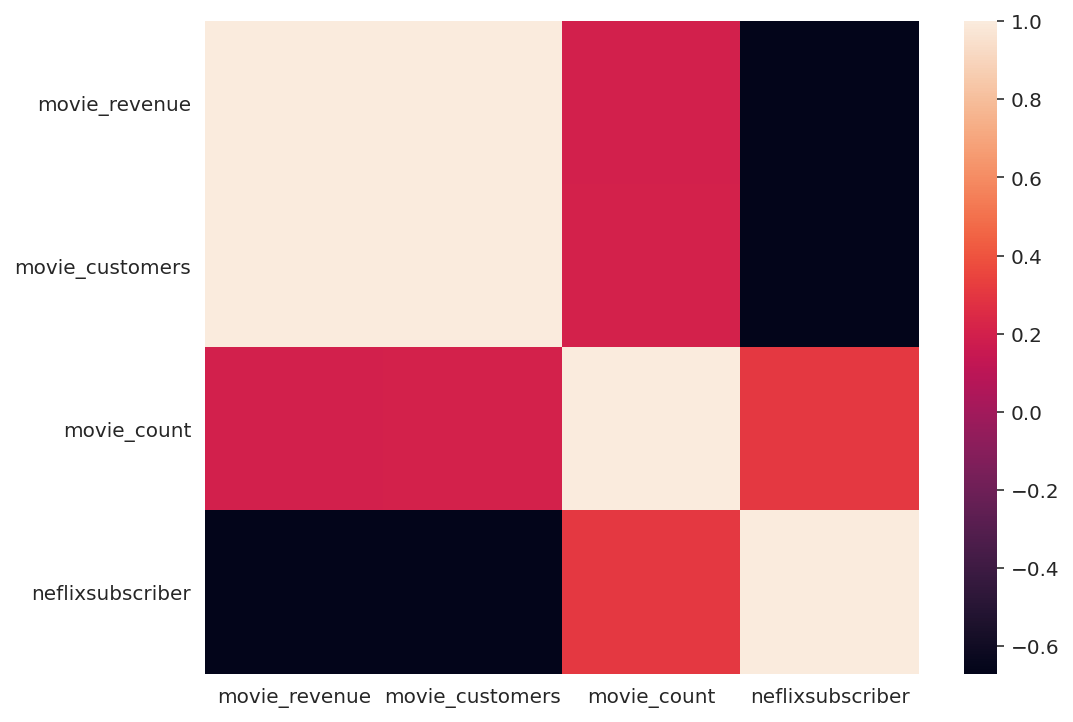

In [88]:
plt.figure(figsize=(8,6))
sns.heatmap(final_mv_df.corr())

#최종 상관 분석

넷플릭스 구독자수와 상관관계가 큰 요소는 무엇일지에 대해서 상관행렬을 그렸다.  
그 결과 상관계수 절대값 0.5를 넘는 것을 기준으로
영화관 수익( = 영화관 고객수), 넷플릭스 코미디 프로그램, international TV Show, 다큐멘터리, TV 드라마, 로맨틱 영화, 가족영화, 범죄 TV쇼, 어린이 TV 등이 있으며 그 순위는 다음과같은 순으로 나타난다.


,movie_revenue,movie_customers,movie_count,neflixsubscriber,International Movies,Dramas,Comedies,International TV Shows,Action & Adventure,Independent Movies,Documentaries,TV Dramas,Romantic Movies,Thrillers,Children & Family Movies,TV Comedies,Crime TV Shows,Horror Movies,Kids' TV
movie_revenue,1.000000,0.999227,0.202625,-0.664907,0.191561,0.043779,-0.003130,0.054131,0.289573,0.279835,0.620564,-0.228391,-0.158225,0.064728,-0.266110,0.009479,-0.300502,0.296299,-0.171279
movie_customers,0.999227,1.000000,0.208344,-0.670818,0.203174,0.053993,-0.000664,0.049745,0.299063,0.281899,0.639209,-0.235762,-0.156752,0.080715,-0.264635,-0.002946,-0.294068,0.301637,-0.183755
movie_count,0.202625,0.208344,1.000000,0.303699,0.373968,0.451856,0.622703,0.606108,0.696085,-0.204213,0.223904,0.249589,0.626784,0.793561,0.465404,0.553610,0.490753,0.192652,0.583101
neflixsubscriber,-0.664907,-0.670818,0.303699,1.000000,0.003158,0.306544,0.608305,0.661036,0.270889,0.054905,-0.509526,0.780931,0.656836,0.475148,0.694781,0.450090,0.764317,0.144157,0.636971
International Movies,0.191561,0.203174,0.373968,0.003158,1.000000,0.813208,0.584660,0.194764,0.610100,0.351578,0.161808,-0.102056,0.524686,0.381596,0.071808,0.393085,0.224431,0.407934,-0.306364
Dramas,0.043779,0.053993,0.451856,0.306544,0.813208,1.000000,0.838519,0.543912,0.862553,0.572121,-0.050696,0.264864,0.804470,0.617071,0.595451,0.579423,0.530974,0.543786,0.089228
Comedies,-0.003130,-0.000664,0.622703,0.608305,0.584660,0.838519,1.000000,0.847056,0.884482,0.502300,-0.151536,0.573497,0.966639,0.802058,0.763293,0.774494,0.716360,0.621825,0.446761
International TV Shows,0.054131,0.049745,0.606108,0.661036,0.194764,0.543912,0.847056,1.000000,0.692639,0.385672,0.018123,0.837285,0.809164,0.746029,0.828775,0.719597,0.799267,0.426748,0.632595
Action & Adventure,0.289573,0.299063,0.696085,0.270889,0.610100,0.862553,0.884482,0.692639,1.000000,0.498351,0.037261,0.309088,0.822903,0.806781,0.659859,0.596253,0.507284,0.630840,0.385012
Independent Movies,0.279835,0.281899,-0.204213,0.054905,0.351578,0.572121,0.502300,0.385672,0.498351,1.000000,-0.038524,0.359875,0.359333,0.242063,0.357414,0.250206,0.284704,0.764421,-0.113850


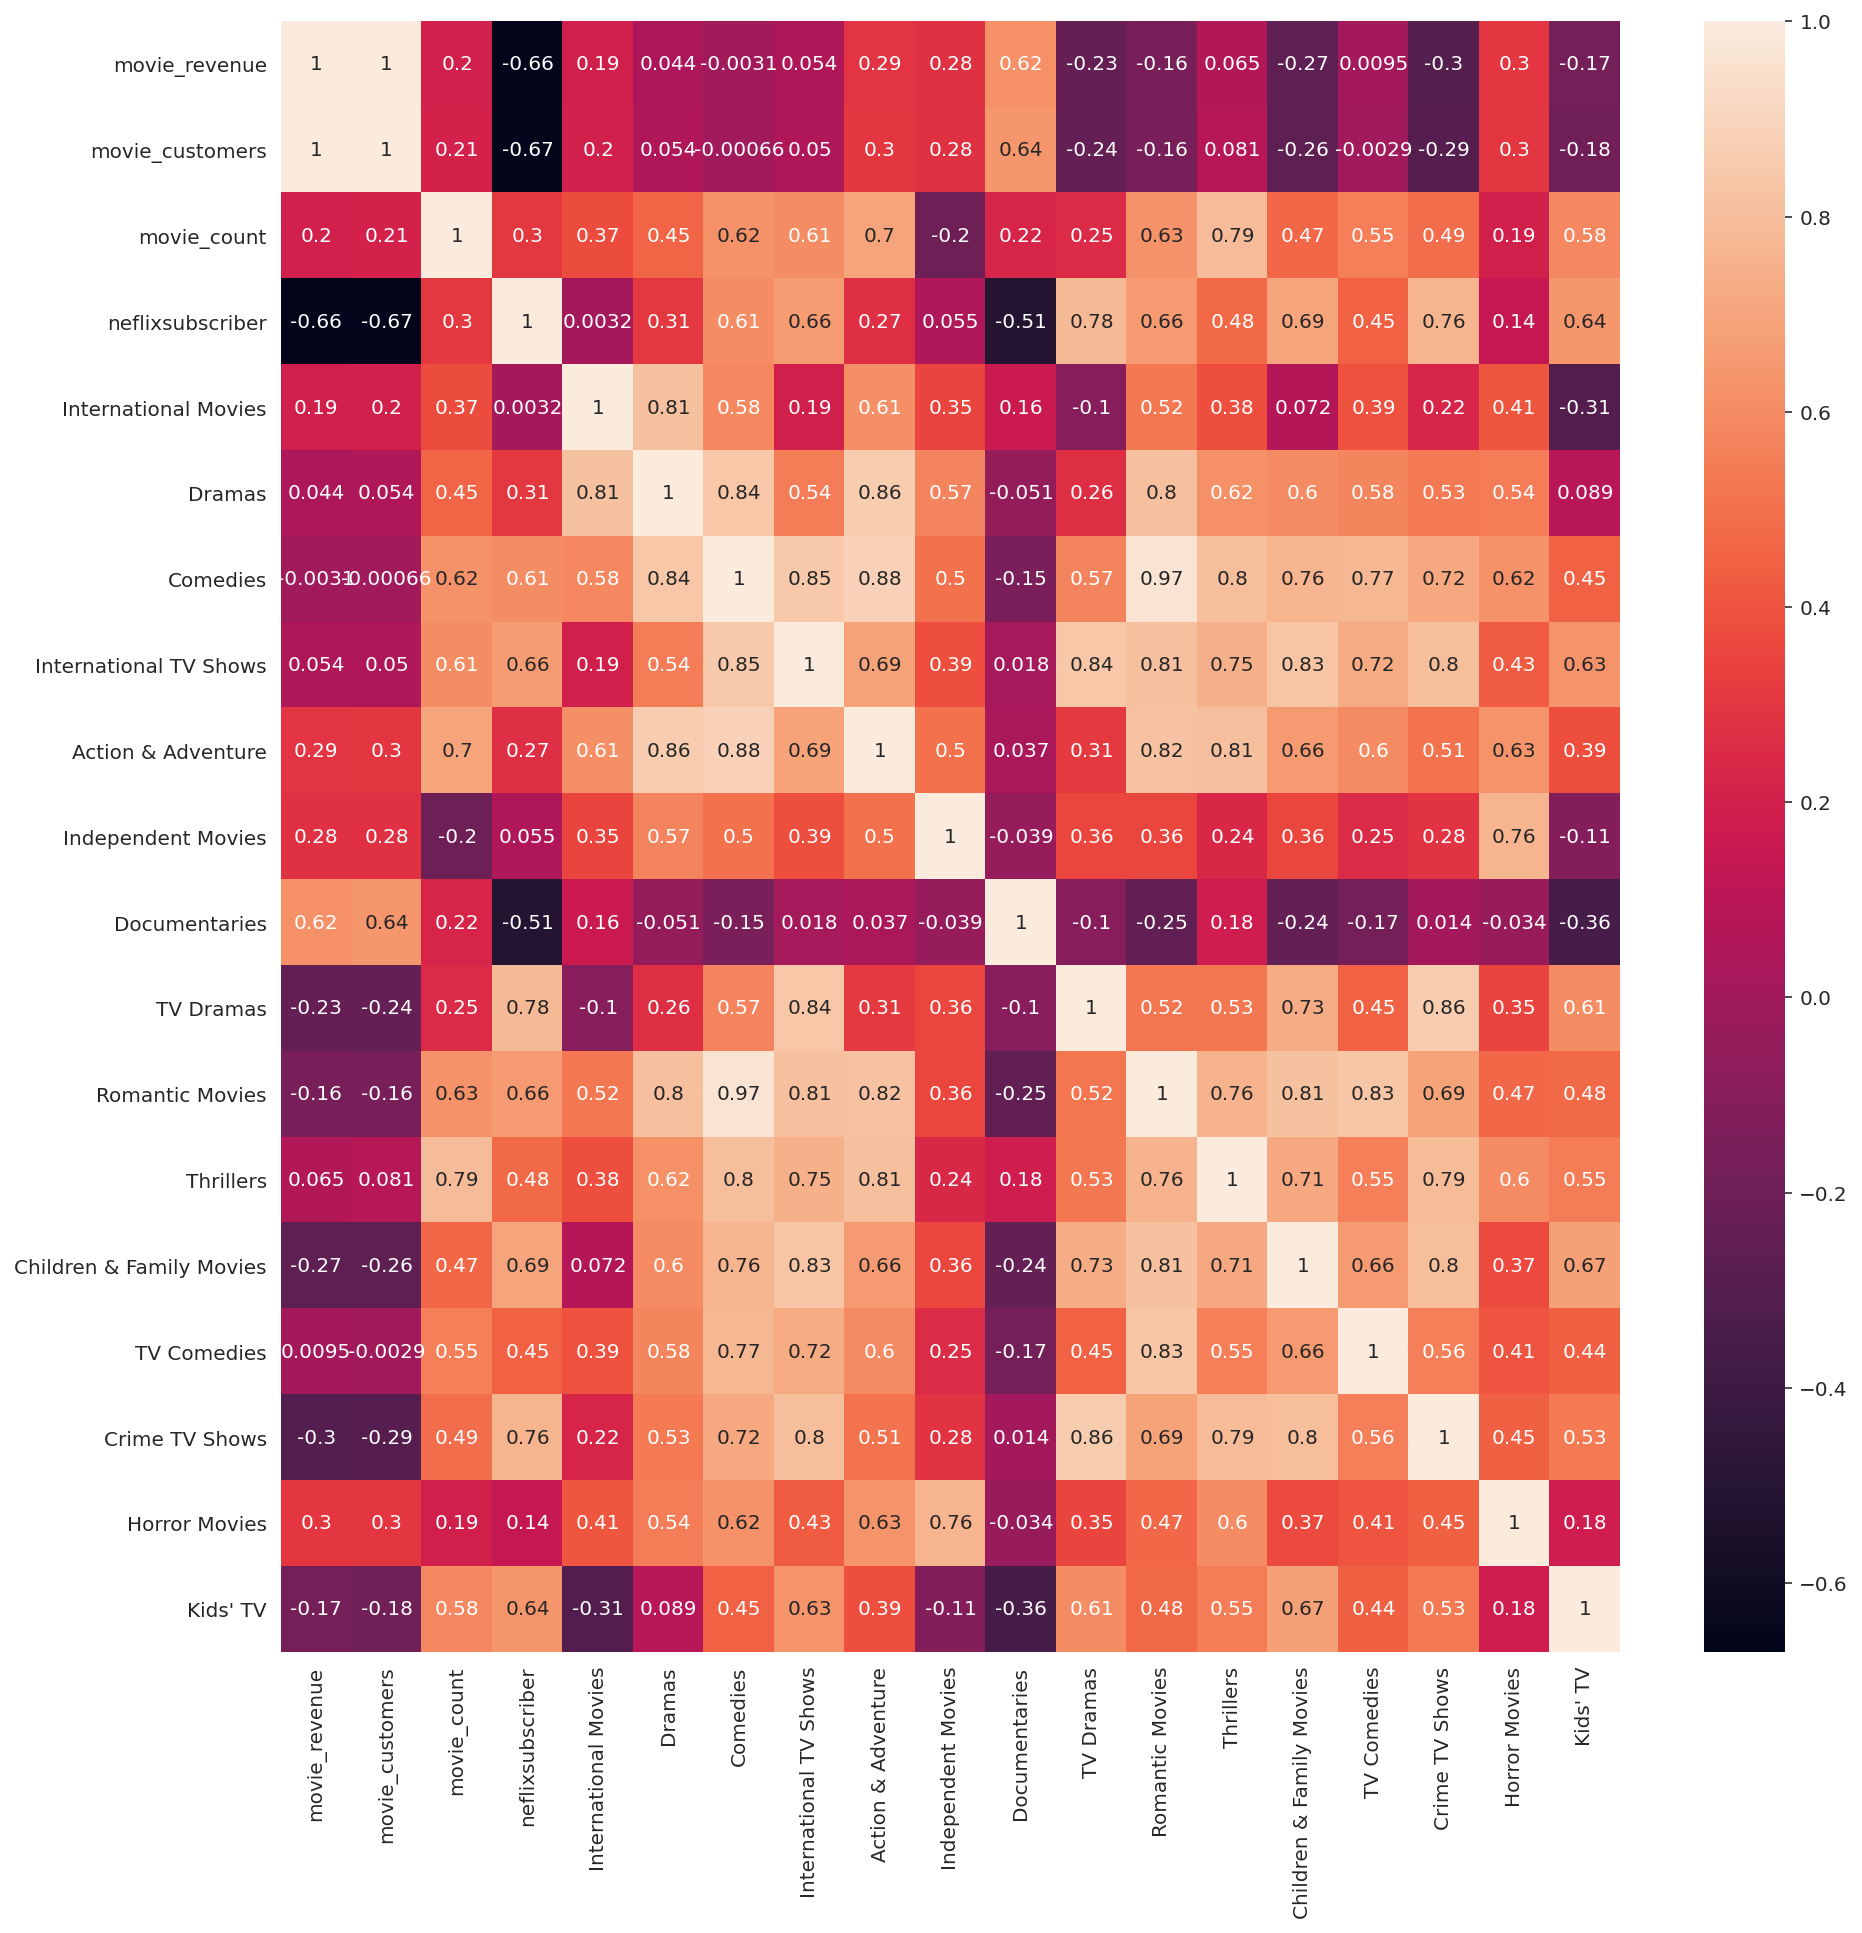

In [141]:
#최종 상관 행렬 및 시각화
final_corr_df = final_mv_df.join(cat_df3)
display(final_corr_df.corr())
plt.figure(figsize=(15,15))
sns.heatmap(final_corr_df.corr(),annot=True)

In [139]:
#상관관계 순위
corr_rank_df = pd.DataFrame(final_corr_df.corr().loc[:,'neflixsubscriber'])

ranking = corr_rank_df.apply(abs)
ranking = ranking.sort_values(by='neflixsubscriber',ascending=False)
ranking['Rank'] = range(len(ranking))
ranking

corr_final_df = corr_rank_df.join(ranking['Rank'])
corr_final_df=corr_final_df[corr_final_df['Rank']!=0]
corr_final_df.sort_values(by='Rank')

,neflixsubscriber,Rank
TV Dramas,0.780931,1
Crime TV Shows,0.764317,2
Children & Family Movies,0.694781,3
movie_customers,-0.670818,4
movie_revenue,-0.664907,5
International TV Shows,0.661036,6
Romantic Movies,0.656836,7
Kids' TV,0.636971,8
Comedies,0.608305,9
Documentaries,-0.509526,10
